Importing Library

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

Read data and filter it based on SICCD 4800 to 4899

In [ ]:
# # Read the CSV from WRDS (estimation period)
# df = pd.read_csv("2000.csv") 

# # Convert the SICCD column to numeric
# df['SICCD'] = pd.to_numeric(df['SICCD'], errors='coerce')

# # Filter the DataFrame for SICCD in the range 4800 to 4899 (Communication)
# communication_df = df[(df['SICCD'] >= 4800) & (df['SICCD'] <= 4899)]

# # Result
# print(communication_df)
# communication_df.to_csv("communication_services_2000.csv", index=False)

In [ ]:
# # Read the CSV file
# df = pd.read_csv("2016.csv") 

# # Convert the SICCD column to numeric, forcing errors to NaN (not a number)
# df['SICCD'] = pd.to_numeric(df['SICCD'], errors='coerce')

# # Filter the DataFrame for SICCD in the range 4800 to 4899
# communication_df = df[(df['SICCD'] >= 4800) & (df['SICCD'] <= 4899)]

# # Result
# print(communication_df)
# communication_df.to_csv("communication_services_2016.csv", index=False)

Checking Missing Data in Estimation Period

In [39]:
estimation_df = pd.read_csv("communication_services_2000.csv") 
outofsample_df = pd.read_csv("communication_services_2016.csv") 

estimation_df.head()
# Check for Missing Values
missing_data = estimation_df.isnull().sum()

# Calculate the percentage of missing data for each column
missing_percentage = (missing_data / len(estimation_df)) * 100

# Create a DataFrame to display the results
missing_info = pd.DataFrame({
    'Missing Values': missing_data,
    'Percentage of Missing Data (%)': missing_percentage
})
print(missing_info)


        Missing Values  Percentage of Missing Data (%)
PERMNO               0                        0.000000
date                 0                        0.000000
SICCD                0                        0.000000
COMNAM               0                        0.000000
PRC              17602                        2.052640
RET                816                        0.095157
SHROUT             417                        0.048628


C:\Users\fazlu\AppData\Local\Temp\ipykernel_4888\2277442323.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  outofsample_df = pd.read_csv("communication_services_2016.csv")


In [42]:
unique_permnos = estimation_df['PERMNO'].unique()

print("Count of all unique PERMNOs:")
print(len(unique_permnos))

# Filter rows with any missing values
rows_with_missing = estimation_df[estimation_df.isnull().any(axis=1)]

# Get unique PERMNOs from those rows
permnos_with_missing = rows_with_missing['PERMNO'].unique()

print("Count of PERMNOs with any missing data:")
print(len(permnos_with_missing))



Count of all unique PERMNOs:
605
Count of PERMNOs with any missing data:
387


In [ ]:
# Step 1: Get all PERMNOs with any missing data
permnos_with_missing = estimation_df[estimation_df.isnull().any(axis=1)]['PERMNO'].unique()

# Step 2: Filter out those PERMNOs from the DataFrame
clean_df = estimation_df[~estimation_df['PERMNO'].isin(permnos_with_missing)]

# Optional: reset index
clean_df = clean_df.reset_index(drop=True)


DataFrame shape after removing PERMNOs with missing data: (431691, 7)


In [ ]:
unique_permnos = clean_df['PERMNO'].unique()

print("All unique PERMNOs after cleaning:")
print(len(unique_permnos))

All unique PERMNOs after cleaning:
218


In [44]:
clean_df.head()

,PERMNO,date,SICCD,COMNAM,PRC,RET,SHROUT,MKT_CAP
0,10066,2000-01-03,4813.0,FRANKLIN TELECOMMUNICATIONS CORP,2.5000,0.000000,28258.0,70645000.0
1,10066,2000-01-04,4813.0,FRANKLIN TELECOMMUNICATIONS CORP,2.3750,-0.050000,28258.0,67112750.0
2,10066,2000-01-05,4813.0,FRANKLIN TELECOMMUNICATIONS CORP,2.3750,0.000000,28258.0,67112750.0
3,10066,2000-01-06,4813.0,FRANKLIN TELECOMMUNICATIONS CORP,2.5000,0.052632,28258.0,70645000.0
4,10066,2000-01-07,4813.0,FRANKLIN TELECOMMUNICATIONS CORP,2.1875,-0.125000,28258.0,61814375.0


Checking full count of full trading days from 2000 to 2015 

In [ ]:
trading_days_count = clean_df.groupby('PERMNO').size()
print(trading_days_count.max())

4025
10


We got the full count is 4025. So we will filter the data to only have 4025 data to ensure the trading has no missing data in estimation period.

In [ ]:

# Daily market cap
clean_df['PRC'] = clean_df['PRC'].abs()
clean_df['MKT_CAP'] = clean_df['PRC'] * clean_df['SHROUT'] * 1000

days_minimum_count = trading_days_count.max()

# Filter for PERMNOs 
valid_permnos = trading_days_count[trading_days_count >= days_minimum_count].index
filtered_df = clean_df[clean_df['PERMNO'].isin(valid_permnos)].copy()

# Compute average market cap on the filtered data
avg_market_caps = (
    filtered_df.groupby('PERMNO')['MKT_CAP']
    .mean()
    .sort_values(ascending=False)
)

# Get top 50 PERMNOs by average market cap (after filtering)
top_50_permnos = avg_market_caps.head(50).index

# Filter to top 50 stocks for both estimation and out-of-sample data
top_50_df = filtered_df[filtered_df['PERMNO'].isin(top_50_permnos)].copy()
top_50_out_df = outofsample_df[outofsample_df['PERMNO'].isin(top_50_permnos)].copy()



Calculate EXCESS_RET using TB3MS data 

In [ ]:

# Load and prepare T-bill data
tbill_2000_df = pd.read_csv("TB3MS_2000.csv")
tbill_2000_df['observation_date'] = pd.to_datetime(tbill_2000_df['observation_date'])
tbill_2000_df['TB3MS'] = pd.to_numeric(tbill_2000_df['TB3MS'], errors='coerce')
tbill_2000_df['DAILY_RF'] = tbill_2000_df['TB3MS'] / 100 / 252 

# Prepare top_50_df
top_50_df['date'] = pd.to_datetime(top_50_df['date'])
tbill_2000_df = tbill_2000_df.sort_values('observation_date')
top_50_df = top_50_df.sort_values('date')

# if 'observation_date' in top_50_df.columns:
#     top_50_df = top_50_df.drop(columns=['observation_date'])

# if 'DAILY_RF' in top_50_df.columns:
#     top_50_df = top_50_df.drop(columns=['DAILY_RF'])

# Merge DAILY_RF with top_50_df based on nearest previous date
top_50_df = pd.merge_asof(
    top_50_df,
    tbill_2000_df[['observation_date', 'DAILY_RF']],
    left_on='date',
    right_on='observation_date',
    direction='backward'
)

# Ensure RET is numeric
top_50_df['RET'] = pd.to_numeric(top_50_df['RET'], errors='coerce')

# Calculate EXCESS_RET
top_50_df['EXCESS_RET'] = top_50_df['RET'] - top_50_df['DAILY_RF']

# =======================================================================

# Load and prepare T-bill data
# Prepare top_50_out_df
top_50_out_df['PRC'] = top_50_out_df['PRC'].abs()
top_50_out_df['MKT_CAP'] = top_50_out_df['PRC'] * top_50_out_df['SHROUT'] * 1000

tbill_2016_df = pd.read_csv("TB3MS_2016.csv")
tbill_2016_df['observation_date'] = pd.to_datetime(tbill_2016_df['observation_date'])
tbill_2016_df['TB3MS'] = pd.to_numeric(tbill_2016_df['TB3MS'], errors='coerce')
tbill_2016_df['DAILY_RF'] = tbill_2016_df['TB3MS'] / 100 / 252  # Annual % → Daily decimal

top_50_out_df['date'] = pd.to_datetime(top_50_out_df['date'])
tbill_2016_df = tbill_2016_df.sort_values('observation_date')
top_50_out_df = top_50_out_df.sort_values('date')


# if 'observation_date' in top_50_out_df.columns:
#     top_50_out_df = top_50_out_df.drop(columns=['observation_date'])

# if 'DAILY_RF' in top_50_out_df.columns:
#     top_50_out_df = top_50_out_df.drop(columns=['DAILY_RF'])

# Merge DAILY_RF with top_50_out_df based on nearest previous date
top_50_out_df = pd.merge_asof(
    top_50_out_df,
    tbill_2016_df[['observation_date', 'DAILY_RF']],
    left_on='date',
    right_on='observation_date',
    direction='backward'
)

# Ensure RET is numeric
top_50_out_df['RET'] = pd.to_numeric(top_50_out_df['RET'], errors='coerce')

# Calculate EXCESS_RET
top_50_out_df['EXCESS_RET'] = top_50_out_df['RET'] - top_50_out_df['DAILY_RF']


In [15]:
display(top_50_df.head())
display(top_50_out_df.head())

,PERMNO,date,SICCD,COMNAM,PRC,RET,SHROUT,MKT_CAP,observation_date,DAILY_RF,EXCESS_RET
0,11174,2000-01-03,4840.0,CROWN GROUP INC,5.10938,0.034810,9711.0,4.961719e+07,2000-01-01,0.000211,0.034599
1,80924,2000-01-03,4830.0,SIRIUS SATELLITE RADIO INC,41.12500,-0.075843,28721.0,1.181151e+09,2000-01-01,0.000211,-0.076054
2,83604,2000-01-03,4812.0,S K TELECOM CO LTD,38.75000,0.009772,123912.0,4.801590e+09,2000-01-01,0.000211,0.009561
3,80297,2000-01-03,4830.0,EMMIS COMMUNICATIONS CORP,113.75000,-0.087376,13418.0,1.526298e+09,2000-01-01,0.000211,-0.087587
4,85421,2000-01-03,4812.0,CHINA TELECOM HONG KONG,139.00000,0.080661,5009.0,6.962510e+08,2000-01-01,0.000211,0.080450


,PERMNO,date,SICCD,COMNAM,PRC,RET,SHROUT,MKT_CAP,observation_date,DAILY_RF,EXCESS_RET
0,11174,2016-01-04,4840.0,AMERICAS CAR MART INC,27.37,0.025478,8447.0,2.311944e+08,2016-01-01,0.00001,0.025468
1,80924,2016-01-04,4832.0,SIRIUS X M HOLDINGS INC,3.95,-0.029484,5147647.0,2.033321e+10,2016-01-01,0.00001,-0.029494
2,80863,2016-01-04,4813.0,NIPPON TELEGRAPH & TELPHONE CORP,39.17,-0.014343,65185.0,2.553296e+09,2016-01-01,0.00001,-0.014353
3,80297,2016-01-04,4830.0,EMMIS COMMUNICATIONS CORP,0.65,0.015625,41340.0,2.687100e+07,2016-01-01,0.00001,0.015615
4,66835,2016-01-04,4813.0,B T GROUP PLC,34.30,-0.008957,25600.0,8.780800e+08,2016-01-01,0.00001,-0.008967


Generate Descriptive Statistic for estimation period

In [50]:
# Descriptive stats for excess return
descriptive_stats = (
    top_50_df.groupby('PERMNO')['EXCESS_RET']
    .agg(['mean', 'std', 'min', 'max', 'count'])
    .reset_index()
)

# # Merge with SICCD
# meta_info = (
#     top_50_df.groupby('PERMNO')[['SICCD']]
#     .first()
#     .reset_index()
# )

# descriptive_stats = descriptive_stats.merge(meta_info, on='PERMNO')

# Add average market cap to the summary
avg_market_caps_df = avg_market_caps.reset_index(name='avg_market_cap')
descriptive_stats = descriptive_stats.merge(avg_market_caps_df, on='PERMNO')

# Final sort
descriptive_stats = descriptive_stats.sort_values(by='avg_market_cap', ascending=False)

# Show results
display(descriptive_stats)


,PERMNO,mean,std,min,max,count,avg_market_cap
6,66093,0.000188,0.016977,-0.126841,0.162774,4024,1.525590e+11
12,76226,0.000362,0.026482,-0.207580,0.265801,4024,3.595443e+10
2,29647,0.000407,0.017044,-0.340481,0.201302,4024,2.612402e+10
13,78405,0.000483,0.020389,-0.103347,0.184334,4024,1.118552e+10
32,86339,0.000725,0.032293,-0.388362,0.312132,4024,1.055480e+10
23,81696,0.000500,0.029008,-0.191488,0.246214,4024,7.598406e+09
14,78840,0.000461,0.024233,-0.200365,0.164154,4024,7.298852e+09
20,80924,0.000742,0.053490,-0.517132,0.894673,4024,7.227508e+09
17,80089,0.000394,0.023109,-0.147663,0.232183,4024,6.774852e+09
29,85991,0.000172,0.045368,-0.394336,0.508583,4024,6.437152e+09


In [51]:
# Descriptive stats for excess return
descriptive_stats_out = (
    top_50_out_df.groupby('PERMNO')['EXCESS_RET']
    .agg(['mean', 'std', 'min', 'max', 'count'])
    .reset_index()
)

# # Merge with company name and SICCD
# meta_info_out = (
#     top_50_out_df.groupby('PERMNO')[['SICCD']]
#     .first()
#     .reset_index()
# )
# descriptive_stats_out = descriptive_stats_out.merge(meta_info_out, on='PERMNO')

avg_market_caps_out = (
    top_50_out_df.groupby('PERMNO')['MKT_CAP']
    .mean()
    .sort_values(ascending=False)
)
# Add average market cap to the summary
avg_market_caps_out_df = avg_market_caps_out.reset_index(name='avg_market_cap_out')
descriptive_stats_out = descriptive_stats_out.merge(avg_market_caps_out_df, on='PERMNO')

# Final sort
descriptive_stats_out = descriptive_stats_out.sort_values(by='avg_market_cap_out', ascending=False)

# Show results
display(descriptive_stats_out)


,PERMNO,mean,std,min,max,count,avg_market_cap_out
6,66093,0.000208,0.014678,-0.104256,0.100211,2263,1.971632e+11
32,86339,0.000866,0.015881,-0.124262,0.113383,1260,4.884763e+10
2,29647,0.000004,0.011719,-0.127147,0.121519,2263,3.969474e+10
36,86996,0.000391,0.017513,-0.089338,0.124280,2263,2.479858e+10
20,80924,0.000010,0.023236,-0.152750,0.422379,2263,2.296739e+10
29,85991,0.000128,0.016042,-0.094120,0.105486,461,1.945526e+10
13,78405,0.000105,0.014111,-0.142151,0.132224,2263,1.836137e+10
12,76226,-0.000194,0.030035,-0.283734,0.307612,2263,1.727511e+10
31,86218,0.000562,0.016966,-0.147422,0.413666,1824,1.057900e+10
14,78840,0.000769,0.024860,-0.177760,0.208489,2263,9.616064e+09


In [ ]:
def add_rolling_features(df, window):
    df = df.sort_values(['PERMNO', 'date']).copy()
    
    # Rolling mean of past EXCESS_RET 
    df[f'rolling_mean_excess_ret_window'] = (
        df.groupby('PERMNO')['EXCESS_RET']
        .transform(lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())
    )
    df = df.dropna()
    return df

In [52]:
# Changeable window
window_sizes = 5

top_50_df = add_rolling_features(top_50_df, window_sizes)
top_50_out_df = add_rolling_features(top_50_out_df, window_sizes)


In [53]:
display(top_50_df)

,PERMNO,date,SICCD,COMNAM,PRC,RET,SHROUT,MKT_CAP,observation_date,DAILY_RF,EXCESS_RET,rolling_mean_excess_ret_window,EXCESS_RET_lag_1,EXCESS_RET_lag_2,EXCESS_RET_lag_3,EXCESS_RET_lag_4,EXCESS_RET_lag_5
275,11174,2000-01-11,4840.0,CROWN GROUP INC,4.75000,-0.025641,9711.0,46127250.00,2000-01-01,0.000211,-0.025852,-0.008276,0.026105,-0.084548,0.063892,-0.025211,-0.021618
336,11174,2000-01-12,4840.0,CROWN GROUP INC,4.75000,0.000000,9711.0,46127250.00,2000-01-01,0.000211,-0.000211,-0.009123,-0.025852,0.026105,-0.084548,0.063892,-0.025211
382,11174,2000-01-13,4840.0,CROWN GROUP INC,4.84375,0.019737,9711.0,47037656.25,2000-01-01,0.000211,0.019526,-0.004123,-0.000211,-0.025852,0.026105,-0.084548,0.063892
401,11174,2000-01-14,4840.0,CROWN GROUP INC,4.87500,0.006452,9711.0,47341125.00,2000-01-01,0.000211,0.006241,-0.012996,0.019526,-0.000211,-0.025852,0.026105,-0.084548
459,11174,2000-01-18,4840.0,CROWN GROUP INC,4.75000,-0.025641,9711.0,46127250.00,2000-01-01,0.000211,-0.025852,0.005162,0.006241,0.019526,-0.000211,-0.025852,0.026105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172875,87373,2015-12-24,4813.0,ALASKA COMMUNICATIONS SYS GRP IN,1.77000,0.005682,50415.0,89234550.00,2015-12-01,0.000009,0.005673,0.002348,0.011485,0.005771,-0.011438,-0.011308,0.017232
172905,87373,2015-12-28,4813.0,ALASKA COMMUNICATIONS SYS GRP IN,1.75000,-0.011299,50415.0,88226250.00,2015-12-01,0.000009,-0.011308,0.000036,0.005673,0.011485,0.005771,-0.011438,-0.011308
172977,87373,2015-12-29,4813.0,ALASKA COMMUNICATIONS SYS GRP IN,1.73000,-0.011429,50415.0,87217950.00,2015-12-01,0.000009,-0.011438,0.000036,-0.011308,0.005673,0.011485,0.005771,-0.011438
173014,87373,2015-12-30,4813.0,ALASKA COMMUNICATIONS SYS GRP IN,1.76000,0.017341,50415.0,88730400.00,2015-12-01,0.000009,0.017332,0.000036,-0.011438,-0.011308,0.005673,0.011485,0.005771


In [21]:
display(top_50_out_df)

,PERMNO,date,SICCD,COMNAM,PRC,RET,SHROUT,MKT_CAP,observation_date,DAILY_RF,EXCESS_RET,rolling_mean_excess_ret_window
75,11174,2016-01-05,4840.0,AMERICAS CAR MART INC,27.430,0.002192,8447.0,231701210.0,2016-01-01,0.000010,0.002182,0.025468
103,11174,2016-01-06,4840.0,AMERICAS CAR MART INC,25.770,-0.060518,8447.0,217679190.0,2016-01-01,0.000010,-0.060528,0.013825
138,11174,2016-01-07,4840.0,AMERICAS CAR MART INC,25.540,-0.008925,8447.0,215736380.0,2016-01-01,0.000010,-0.008935,-0.010960
204,11174,2016-01-08,4840.0,AMERICAS CAR MART INC,25.020,-0.020360,8447.0,211343940.0,2016-01-01,0.000010,-0.020370,-0.010454
244,11174,2016-01-11,4840.0,AMERICAS CAR MART INC,24.410,-0.024381,8447.0,206191270.0,2016-01-01,0.000010,-0.024391,-0.012437
...,...,...,...,...,...,...,...,...,...,...,...,...
51091,87373,2021-07-16,4813.0,ALASKA COMMUNICATIONS SYS GRP IN,3.375,0.007463,54274.0,183174750.0,2021-07-01,0.000002,0.007461,0.000007
51115,87373,2021-07-19,4813.0,ALASKA COMMUNICATIONS SYS GRP IN,3.380,0.001482,54274.0,183446120.0,2021-07-01,0.000002,0.001480,0.002097
51165,87373,2021-07-20,4813.0,ALASKA COMMUNICATIONS SYS GRP IN,3.380,0.000000,54274.0,183446120.0,2021-07-01,0.000002,-0.000002,0.001794
51196,87373,2021-07-21,4813.0,ALASKA COMMUNICATIONS SYS GRP IN,3.390,0.002959,54274.0,183988860.0,2021-07-01,0.000002,0.002957,0.001794


In [22]:
top_50_df.to_csv("top50_estimation.csv", index=False)
top_50_out_df.to_csv("top50_outofsample.csv",index=False)

In [23]:
highest_marketcap_df = top_50_df[top_50_df['PERMNO'] == top_permno]
display(highest_marketcap_df)

,PERMNO,date,SICCD,COMNAM,PRC,RET,SHROUT,MKT_CAP,observation_date,DAILY_RF,EXCESS_RET,rolling_mean_excess_ret_window
69,66093,2000-01-04,4813.0,S B C COMMUNICATIONS INC,44.2500,-0.062252,3411379.0,1.509535e+11,2000-01-01,0.000211,-0.062463,-0.032262
109,66093,2000-01-05,4813.0,S B C COMMUNICATIONS INC,44.9375,0.015537,3411379.0,1.532988e+11,2000-01-01,0.000211,0.015326,-0.047363
130,66093,2000-01-06,4813.0,S B C COMMUNICATIONS INC,43.7500,-0.021001,3411379.0,1.492478e+11,2000-01-01,0.000211,-0.021212,-0.026466
207,66093,2000-01-07,4813.0,S B C COMMUNICATIONS INC,44.1250,0.008571,3411379.0,1.505271e+11,2000-01-01,0.000211,0.008360,-0.025153
215,66093,2000-01-10,4813.0,S B C COMMUNICATIONS INC,44.7500,0.014164,3411379.0,1.526592e+11,2000-01-01,0.000211,0.013953,-0.018450
...,...,...,...,...,...,...,...,...,...,...,...,...
172887,66093,2015-12-24,4813.0,A T & T INC,34.6600,-0.003450,6152000.0,2.132283e+11,2015-12-01,0.000009,-0.003459,0.002257
172913,66093,2015-12-28,4813.0,A T & T INC,34.7600,0.002885,6152000.0,2.138435e+11,2015-12-01,0.000009,0.002876,0.003718
172968,66093,2015-12-29,4813.0,A T & T INC,34.9300,0.004891,6152000.0,2.148894e+11,2015-12-01,0.000009,0.004882,0.006822
172991,66093,2015-12-30,4813.0,A T & T INC,34.7400,-0.005439,6152000.0,2.137205e+11,2015-12-01,0.000009,-0.005448,0.004884


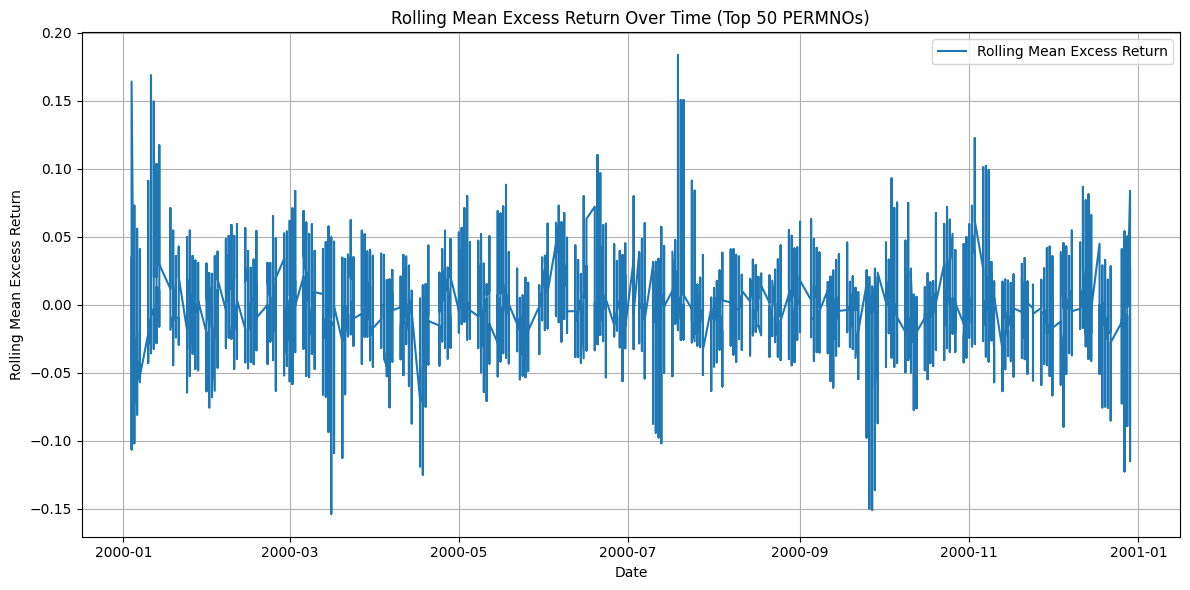

In [24]:
import matplotlib.pyplot as plt

# Make sure 'date' is in datetime format

# Sort by date
top_50_df = top_50_df.sort_values('date')
df_2000 = top_50_df[top_50_df['date'].dt.year == 2000]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_2000['date'], df_2000['rolling_mean_excess_ret_window'], label='Rolling Mean Excess Return')
plt.xlabel('Date')
plt.ylabel('Rolling Mean Excess Return')
plt.title('Rolling Mean Excess Return Over Time (Top 50 PERMNOs)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

# Parameters

LAGS = 5
TARGET = 'EXCESS_RET'
ROLLING_FEATURE = 'rolling_mean_excess_ret_window'

results = []

# Function to create lagged features for a stock
def create_lags(df, lags=5, target='EXCESS_RET'):
    df = df.sort_values(by='date')
    for lag in range(1, lags + 1):
        df[f'{target}_lag_{lag}'] = df[target].shift(lag)
    return df

# Process each stock
for permno in top_50_df['PERMNO'].unique():
    # Filter stock-specific data
    train_stock = top_50_df[top_50_df['PERMNO'] == permno].copy()
    test_stock = top_50_out_df[top_50_out_df['PERMNO'] == permno].copy()
    
    if train_stock.empty or test_stock.empty:
        continue

    # Add lagged features
    train_stock = create_lags(train_stock, LAGS, TARGET)
    train_stock = train_stock.dropna()

    # Build lag features in test set using last few rows from training
    last_train_rows = train_stock.sort_values(by='date').tail(LAGS)
    for i, row in test_stock.iterrows():
        for lag in range(1, LAGS + 1):
            lag_val = last_train_rows.iloc[-lag][TARGET] if len(last_train_rows) >= lag else np.nan
            test_stock.at[i, f'{TARGET}_lag_{lag}'] = lag_val

    test_stock = test_stock.dropna()

    features = [f'{TARGET}_lag_{i}' for i in range(1, LAGS + 1)] + [ROLLING_FEATURE]

    X_train = train_stock[features]
    y_train = train_stock[TARGET]
    X_test = test_stock[features]
    y_test = test_stock[TARGET]

    if X_train.empty or X_test.empty:
        continue

    # Lasso
    lasso = LassoCV(cv=3).fit(X_train, y_train)
    lasso_pred = lasso.predict(X_test)

    r2_lasso = r2_score(y_test, lasso_pred)
    mse_lasso = mean_squared_error(y_test, lasso_pred)
    mae_lasso = mean_absolute_error(y_test, lasso_pred)

    results.append({
        'PERMNO': permno,
        'Model': 'Lasso',
        'Window': window_sizes,
        'R2': r2_lasso,
        'MSE': mse_lasso,
        'MAE': mae_lasso
    })

    # Ridge
    ridge = RidgeCV(cv=3).fit(X_train, y_train)
    ridge_pred = ridge.predict(X_test)

    r2_ridge = r2_score(y_test, ridge_pred)
    mse_ridge = mean_squared_error(y_test, ridge_pred)
    mae_ridge = mean_absolute_error(y_test, ridge_pred)

    results.append({
        'PERMNO': permno,
        'Model': 'Ridge',
        'Window': window_sizes,
        'R2': r2_ridge,
        'MSE': mse_ridge,
        'MAE': mae_ridge
    })

# Combine all results
result_df = pd.DataFrame(results)




,PERMNO,Model,Window,R2,MSE,MAE
0,11174,Lasso,5,-0.000013,0.001077,0.021370
1,11174,Ridge,5,-0.000221,0.001077,0.021392
2,80924,Lasso,5,-0.001284,0.000540,0.014344
3,80924,Ridge,5,-0.001842,0.000541,0.014349
4,83604,Lasso,5,-0.000028,0.000232,0.010924
...,...,...,...,...,...,...
81,78405,Ridge,5,-0.000673,0.000199,0.009372
82,29647,Lasso,5,-0.001202,0.000137,0.007417
83,29647,Ridge,5,-0.001320,0.000137,0.007417
84,12173,Lasso,5,-0.002438,0.001090,0.015114


In [ ]:
# Group by Model and Window, then calculate the mean
average_metrics = result_df.groupby(['Model', 'Window'])[['R2', 'MSE', 'MAE']].mean().reset_index()
print(average_metrics)

   Model  Window        R2       MSE       MAE
0  Lasso       5 -0.002709  0.001149  0.017642
1  Ridge       5 -0.002009  0.001148  0.017614


In [36]:
lasso_df = result_df[result_df['Model'] == 'Lasso']
display(lasso_df)

ridge_df = result_df[result_df['Model'] == 'Ridge']
display(ridge_df)


,PERMNO,Model,Window,R2,MSE,MAE
0,11174,Lasso,5,-1.297986e-05,0.001077,0.021370
2,80924,Lasso,5,-1.284198e-03,0.000540,0.014344
4,83604,Lasso,5,-2.775515e-05,0.000232,0.010924
6,80297,Lasso,5,-4.881785e-02,0.001410,0.023387
8,85421,Lasso,5,-8.327340e-03,0.000199,0.009866
10,79033,Lasso,5,-3.717091e-04,0.000600,0.016055
12,85991,Lasso,5,-1.335946e-05,0.000257,0.010421
14,78840,Lasso,5,-1.619598e-04,0.000618,0.017132
16,86218,Lasso,5,-1.471042e-04,0.000288,0.009021
18,76226,Lasso,5,-3.302550e-04,0.000902,0.019276


,PERMNO,Model,Window,R2,MSE,MAE
1,11174,Ridge,5,-0.000221,0.001077,0.021392
3,80924,Ridge,5,-0.001842,0.000541,0.014349
5,83604,Ridge,5,-0.000331,0.000232,0.010926
7,80297,Ridge,5,-0.016165,0.001366,0.022583
9,85421,Ridge,5,-0.010581,0.000200,0.009887
11,79033,Ridge,5,-0.000258,0.000600,0.016051
13,85991,Ridge,5,-0.000342,0.000257,0.010424
15,78840,Ridge,5,-0.000028,0.000618,0.017131
17,86218,Ridge,5,-0.000132,0.000288,0.009021
19,76226,Ridge,5,-0.000424,0.000902,0.019277
